<a href="https://colab.research.google.com/github/Sirabhop/Preclinical-AD-EEG-classification/blob/master/Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
from google.colab import drive
from oauth2client.service_account import ServiceAccountCredentials

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gspread

os.chdir("/content/drive/My Drive/Colab Notebooks")
%run EEG_Feature_Extraction.ipynb

updated 11:37


In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.chdir("/content/drive/My Drive/EEG Data")

In [0]:
#Set up google drive API

scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('credentials.json', scope)
client = gspread.authorize(creds)

# **Descriptive Statistics**

####**Demographics**

In [0]:
dict = {'sex': ['male', 'female', 'female', 'female', 'female', 'female', 'female', 'female'],
        'ages':[63, 60, 66, 68, 72, 74, 61, 64],
        'group': [0,1,1,0,1,1,0,0]} #0 = Risk Free, 1 = At risk

In [7]:
df = pd.DataFrame(data = dict)
df

,sex,ages,group
0,male,63,0
1,female,60,1
2,female,66,1
3,female,68,0
4,female,72,1
5,female,74,1
6,female,61,0
7,female,64,0


####**Cognitive Markers**


In [0]:
gsheet_MoCA = client.open("MoCA DATA").sheet1
gsheet_FCSRT = client.open("FCSRT DATA").sheet1
list_MoCA = gsheet_MoCA.get_all_records()
list_FCSRT = gsheet_FCSRT.get_all_records()

In [0]:
FCSRT = pd.DataFrame(list_FCSRT)
MoCA = pd.DataFrame(list_MoCA)

MoCA = pd.concat([df, MoCA], axis = 1).drop(['NAME','SEX','AGE'], axis = 1)
CogMarkers = pd.concat([df, FCSRT, MoCA[['SUM']]], axis = 1)
CogMarkers['group'] = CogMarkers['group'].astype('category')
CogMarkers.set_index('id', inplace = True)
CogMarkers.rename(columns = {'SUM':'MoCA'}, inplace = True)
#CogMarkers.to_csv('cognitive marker.csv')

* **% Encoded**
  * SOMI 0: > 95.8%
  * SOMI 1: > 95.8%
  * SOMI 2a: > 95.8%
  * SOMI 2b: > 93.75 and < 95.8%
  * SOMI 4: > 68.78 and < 91.67%



In [0]:
#computed from [Total Recall x 100]/16
CogMarkers['%Encoded'] = ((CogMarkers['IR-FreeR']+CogMarkers['IR-CuedR'])*100)/16 

*   **% Retrieval**
  * SOMI 0: > 62.5%
  * SOMI 1: > 52.1% and < 62.5%
  * SOMI 2a: > 41.6% and < 50%
  * SOMI 2b: > 41.6% and < 50%
  * SOMI 4: Any


In [0]:
CogMarkers['%Retrieval'] =  CogMarkers['IR-FreeR']*100/16

*   **Classify SS according to SOMI model criteria**


In [0]:
for i in range(-1,7):
  if (CogMarkers.iloc[i, 8] > 95.8) & (CogMarkers.iloc[i, 9] > 62.5):
    CogMarkers['SOMI stage'] = 'SOMI 0'

  if (CogMarkers.iloc[i, 8] > 95.8):
    if (CogMarkers.iloc[i, 9] > 52.1) & (CogMarkers.iloc[i, 9] < 62.5):
      CogMarkers['SOMI stage'] = 'SOMI 1'

  if (CogMarkers.iloc[i, 8] > 95.8):
    if (CogMarkers.iloc[i, 9] > 41.6) & (CogMarkers.iloc[i, 9] < 50):
      CogMarkers['SOMI stage'] = 'SOMI 2a'

  if (CogMarkers.iloc[i, 8] > 93.75) & (CogMarkers.iloc[i, 8] < 95.8):
    if (CogMarkers.iloc[i, 9] > 41.6) & (CogMarkers.iloc[i, 9] < 50):
      CogMarkers['SOMI stage'] = 'SOMI 2b'

  if (CogMarkers.iloc[i, 8] > 68.78) & (CogMarkers.iloc[i, 8] < 91.67):
    if CogMarkers.iloc[i, 9] <= 41.6:
      CogMarkers['SOMI stage'] = 'SOMI 4'
  else:
    CogMarkers['SOMI stage'] = 'NaN'

In [0]:
Cog_Normal = CogMarkers[CogMarkers['group'] == 0]
Cog_Risk = CogMarkers[CogMarkers['group'] == 1]

* **in depth of MoCA score**



In [0]:
MoCA_RiskFree = MoCA[MoCA['group'] == 0]
MoCA_Risk = MoCA[MoCA['group'] == 1]

In [0]:
MoCA_Risk.describe()

,ages,group,VISUO/EXCEUTIVE,NAMING,ATTENTION,LANGUAGE,ABSTRACTION,DELAYED RECALL,ORIENTATION,SUM
count,4.000000,4.0,4.000000,4.00000,4.000000,4.00,4.0,4.0,4.000000,4.00
mean,68.000000,1.0,1.750000,2.50000,2.000000,0.25,0.0,0.0,4.250000,10.75
std,6.324555,0.0,1.258306,0.57735,1.154701,0.50,0.0,0.0,2.362908,3.50
min,60.000000,1.0,0.000000,2.00000,1.000000,0.00,0.0,0.0,1.000000,7.00
25%,64.500000,1.0,1.500000,2.00000,1.000000,0.00,0.0,0.0,3.250000,8.50
50%,69.000000,1.0,2.000000,2.50000,2.000000,0.00,0.0,0.0,5.000000,10.50
75%,72.500000,1.0,2.250000,3.00000,3.000000,0.25,0.0,0.0,6.000000,12.75
max,74.000000,1.0,3.000000,3.00000,3.000000,1.00,0.0,0.0,6.000000,15.00


In [0]:
MoCA_RiskFree.describe()

,ages,group,VISUO/EXCEUTIVE,NAMING,ATTENTION,LANGUAGE,ABSTRACTION,DELAYED RECALL,ORIENTATION,SUM
count,4.00000,4.0,4.00000,4.0,4.000000,4.00,4.00000,4.000000,4.00000,4.000000
mean,64.00000,0.0,4.50000,3.0,4.750000,1.75,0.50000,2.500000,5.50000,17.250000
std,2.94392,0.0,0.57735,0.0,0.957427,0.50,0.57735,2.081666,0.57735,7.544314
min,61.00000,0.0,4.00000,3.0,4.000000,1.00,0.00000,0.000000,5.00000,6.000000
25%,62.50000,0.0,4.00000,3.0,4.000000,1.75,0.00000,1.500000,5.00000,16.500000
50%,63.50000,0.0,4.50000,3.0,4.500000,2.00,0.50000,2.500000,5.50000,20.500000
75%,65.00000,0.0,5.00000,3.0,5.250000,2.00,1.00000,3.500000,6.00000,21.250000
max,68.00000,0.0,5.00000,3.0,6.000000,2.00,1.00000,5.000000,6.00000,22.000000


In [0]:
per_cog_risk = Cog_Risk.copy()
per_cog_normal = Cog_Normal.copy()

In [0]:
per_cog_risk['IR-FreeR'] = (Cog_Risk['IR-FreeR']*100)/16
per_cog_risk['IR-CuedR'] = (Cog_Risk['IR-CuedR']*100)/(16-Cog_Risk['IR-FreeR'])
per_cog_risk['DL-FreeR'] = (Cog_Risk['DL-FreeR']*100)/16
per_cog_risk['DL-CuedR'] = (Cog_Risk['DL-CuedR']*100)/(16-Cog_Risk['DL-FreeR'])

per_cog_normal['IR-FreeR'] = (Cog_Normal['IR-FreeR']*100)/16
per_cog_normal['IR-CuedR'] = (Cog_Normal['IR-CuedR']*100)/(16-Cog_Normal['IR-FreeR'])
per_cog_normal['DL-FreeR'] = (Cog_Normal['DL-FreeR']*100)/16
per_cog_normal['DL-CuedR'] = (Cog_Normal['DL-CuedR']*100)/(16-Cog_Normal['DL-FreeR'])



*   **Graph**



In [0]:
def create_plot_df(Normal, Risk):
  plot_risk = Risk.drop(['sex', 'ages', 'group', 'MoCA', '%Encoded', '%Retrieval',	'SOMI stage'], axis =1)
  plot_risk = plot_risk.transpose()
  plot_risk = plot_risk.reset_index()
  plot_risk['mean'] = plot_risk.mean(axis = 1)

  plot_normal = Normal.drop(['sex', 'ages', 'group', 'MoCA', '%Encoded', '%Retrieval',	'SOMI stage'], axis =1)
  plot_normal = plot_normal.transpose()
  plot_normal = plot_normal.reset_index()
  plot_normal['mean'] = plot_normal.mean(axis = 1)

  return plot_normal, plot_risk

In [0]:
def plot_markers(plot_data, xlab, ylab, title):
  columns_risk = plot_data.drop(['index', 'mean'], axis = 1)
  title = title

  fig, ax = plt.subplots()
  for subjects in columns_risk:
      ax.plot(plot_data['index'], plot_data[subjects])
  ax.set_title(title)
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  plt.savefig('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/Graphs/'+ title +'.png')

  return ax.plot()

In [0]:
def plot_mean_markers(plot_normal, plot_risk, xlab, ylab, title):
  title = title

  fig, ax = plt.subplots()
  ax.plot(plot_risk['index'], plot_risk['mean'], label = 'Risk group')
  ax.plot(plot_normal['index'], plot_normal['mean'], label = 'Normal group')
  ax.set_title(title)
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.legend()
  plt.savefig('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/Graphs/'+ title +'.png')
  return ax.plot()

[]

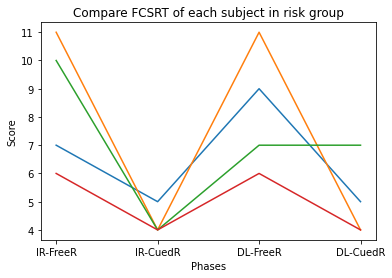

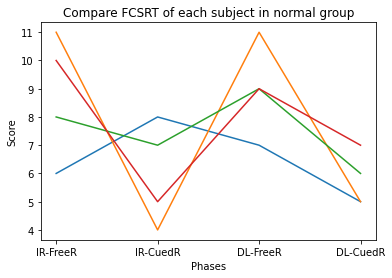

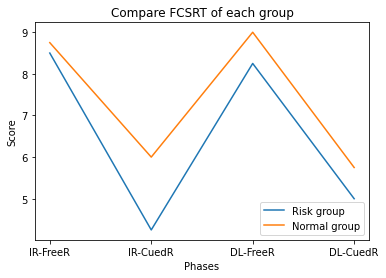

In [19]:
plot_cog_normal, plot_cog_risk = create_plot_df(Cog_Normal, Cog_Risk)
plot_markers(plot_cog_risk, 'Phases', 'Score', 'Compare FCSRT of each subject in risk group')
plot_markers(plot_cog_normal, 'Phases', 'Score', 'Compare FCSRT of each subject in normal group')
plot_mean_markers(plot_cog_normal, plot_cog_risk, 'Phases', 'Score', 'Compare FCSRT of each group')

[]

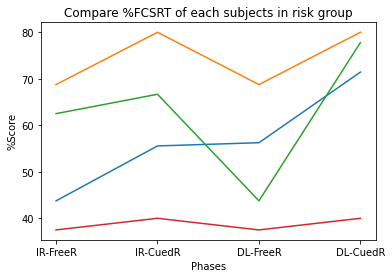

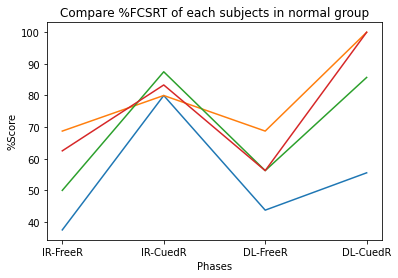

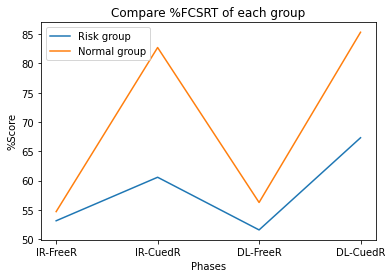

In [20]:
plot_cog_normal, plot_cog_risk = create_plot_df(per_cog_normal, per_cog_risk)
plot_markers(plot_cog_risk, 'Phases', '%Score', 'Compare %FCSRT of each subjects in risk group')
plot_markers(plot_cog_normal, 'Phases', '%Score', 'Compare %FCSRT of each subjects in normal group')
plot_mean_markers(plot_cog_normal, plot_cog_risk, 'Phases', '%Score', 'Compare %FCSRT of each group')

####**Biomarkers**

In [22]:
features = pd.read_csv('EEG_features.csv')
features.drop(['Unnamed: 0'], inplace = True, axis = 1)
Biomarkers = pd.concat([df, features], axis = 1)
Biomarkers.set_index('id', inplace = True)

Biomarkers

,sex,ages,group,PSD_Delta,PSD_Theta,PSD_Alpha,PSD_Beta,PSD_Gamma,MSF,SE,AC,wSMI_Alpha,wSMI_Theta
id,,,,,,,,,,,,,
SS1,male,63,0,8.191509e-14,6.892579e-13,6.892579e-13,2.206398e-13,9.171605e-14,1.674815e-13,2.513122,0.047027,0.069328,0.034951
SS2,female,60,1,1.159327e-13,9.541812e-13,9.541812e-13,5.450232e-13,1.249077e-13,2.717361e-13,2.476574,0.052528,0.065172,0.032267
SS3,female,66,1,9.004434e-14,7.554926e-13,7.554926e-13,5.202362e-13,5.302625e-13,4.418246e-13,2.483961,0.064709,0.060440,0.028957
SS4,female,68,0,9.099951e-14,1.023456e-12,1.023456e-12,4.707961e-13,2.931868e-13,3.786596e-13,2.476574,0.051643,0.051035,0.026086
SS5,female,72,1,1.059632e-13,9.294080e-13,9.294080e-13,5.621714e-13,1.519682e-13,2.856214e-13,2.407455,0.059398,0.065278,0.031481
SS6,female,74,1,5.203354e-14,4.367775e-13,4.367775e-13,1.945097e-13,9.020467e-14,1.481936e-13,2.407455,0.054304,0.067014,0.032455
SS7,female,61,0,1.679208e-13,1.454488e-12,1.454488e-12,8.374338e-13,5.455973e-13,6.437365e-13,2.492098,0.055813,0.064430,0.031130
SS8,female,64,0,6.228747e-14,5.084000e-13,5.084000e-13,3.189277e-13,2.124069e-13,2.546724e-13,2.407455,0.065214,0.063654,0.031456


In [68]:
import mne

risk = ['SS2','SS3','SS5','SS6']
normal = ['SS1', 'SS4', 'SS7', 'SS8']

psd_risk = get_psd_sorce(risk)
psd_normal = get_psd_sorce(normal)
psd_normal.to_csv('/content/drive/My Drive/EEG Data/psd_normal.csv')
psd_risk.to_csv('/content/drive/My Drive/EEG Data/psd_risk.csv')

updated 25/4/2020, 11.54


In [129]:
psd_normal = pd.read_csv('psd_normal.csv').drop(['Unnamed: 0', 'PO3', 'O1'], axis = 1)
psd_risk = pd.read_csv('psd_risk.csv').drop(['Unnamed: 0', 'PO3', 'O1'], axis = 1)
psd_normal['bands'] = ['delta', 'theta', 'alpha', 'beta', 'gamma']
psd_normal.set_index('bands', inplace = True)
psd_risk['bands'] = ['delta', 'theta', 'alpha', 'beta', 'gamma']
psd_risk.set_index('bands', inplace = True)

plot_normal = psd_normal.transpose().reset_index()
plot_risk = psd_risk.transpose().reset_index()

index = plot_normal['index']

plot_normal

bands,index,delta,theta,alpha,beta,gamma
0,Fp1,1.323440e-12,1.140154e-11,1.140154e-11,3.286668e-12,2.819770e-12
1,AF3,7.364839e-13,6.203755e-12,6.203755e-12,1.557490e-12,5.974399e-13
2,F7,6.226717e-13,5.169867e-12,5.169867e-12,2.370487e-12,2.456698e-12
3,F3,4.411544e-13,3.429793e-12,3.429793e-12,1.545341e-12,1.070973e-12
4,FC1,2.501699e-13,1.844128e-12,1.844128e-12,8.701824e-13,3.227146e-13
5,FC5,3.385741e-13,2.522567e-12,2.522567e-12,1.688916e-12,1.991471e-12
6,T7,2.139188e-13,1.604344e-12,1.604344e-12,1.194274e-12,1.278845e-12
7,C3,1.685859e-13,1.235178e-12,1.235178e-12,7.301231e-13,4.709480e-13
8,CP1,9.592233e-14,6.983462e-13,6.983462e-13,3.753163e-13,1.123615e-13
9,CP5,1.278646e-13,9.482106e-13,9.482106e-13,6.093335e-13,4.766180e-13


In [130]:
from sklearn import preprocessing

#Min-Max Scaling
index = plot_normal['index']
plot_normal.drop('index', inplace = True, axis = 1)
scaler = preprocessing.MinMaxScaler()
plot_normal[plot_normal.columns] = scaler.fit_transform(plot_normal[plot_normal.columns])

#df_original.to_csv('Data.csv')
plot_normal.head()
#df = df_original

bands,delta,theta,alpha,beta,gamma
0,0.810161,0.812367,0.812367,0.555830,0.381135
1,0.439237,0.431708,0.431708,0.246942,0.072514
2,0.367314,0.355991,0.355991,0.392170,0.330714
3,0.252605,0.228557,0.228557,0.244772,0.138275
4,0.131914,0.112431,0.112431,0.124167,0.034362


In [0]:
plot_normal = pd.concat((index, plot_normal), axis = 1)

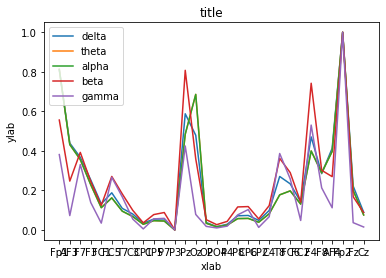

In [132]:
#title = title
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']

fig, ax = plt.subplots()
for band in bands:
  ax.plot(plot_normal['index'], plot_normal[band], label = band)
ax.set_title('title')
ax.set_xlabel('xlab')
ax.set_ylabel('ylab')
ax.legend()
#plt.savefig('/content/drive/My Drive/My Project/Senior Project-Dementia/Results/Graphs/'+ title +'.png')

* **PSD Graph**

In [0]:
Bio_N = Biomarkers[Biomarkers['group'] == 0]
Bio_R = Biomarkers[Biomarkers['group'] == 1]

plot_bio_r = Bio_R.drop(['sex', 'ages', 'group'], axis =1)
plot_bio_n = Bio_N.drop(['sex', 'ages', 'group'], axis =1)

plot_bio_r = plot_bio_r.transpose()
plot_bio_r = plot_bio_r.reset_index()
plot_bio_r = plot_bio_r.loc[0:4]

plot_bio_n = plot_bio_n.transpose()
plot_bio_n = plot_bio_n.reset_index()
plot_bio_n = plot_bio_n.loc[0:4]

In [0]:
plot_bio_r['mean'] = plot_bio_r.mean(axis = 1)
plot_bio_n['mean'] = plot_bio_n.mean(axis = 1)

[]

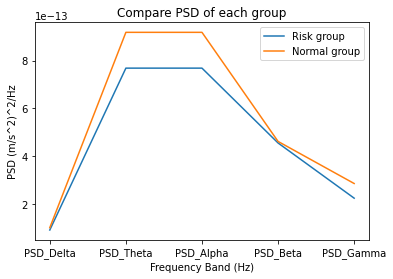

In [25]:
plot_mean_markers(plot_bio_n, plot_bio_r, 'Frequency Band (Hz)', 'PSD (m/s^2)^2/Hz', 'Compare PSD of each group')

# **Inferencial Statistics**

####**Cognitive Markers**

In [0]:
import scipy
import matplotlib.pyplot as plt

* 1-way ANOVA (Risk vs Free Risk)



In [0]:
#Encoding
print(scipy.stats.f_oneway(Cog_Risk['IR-CuedR'], Cog_RiskFree['IR-CuedR'])) #sig

#Retrieval
print(scipy.stats.f_oneway(Cog_Risk['IR-FreeR'], Cog_RiskFree['IR-FreeR'])) #sig

F_onewayResult(statistic=3.4186046511627906, pvalue=0.11395633124158694)
F_onewayResult(statistic=0.023622047244094488, pvalue=0.8828895569688998)


In [0]:
CogMarkers2 = CogMarkers
CogMarkers2['group'][CogMarkers2['group'] == 0] = 'Normal'
CogMarkers2['group'][CogMarkers2['group'] == 1] = 'Risk'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
CogMarkers2

,sex,ages,group,IR-FreeR,IR-CuedR,DL-FreeR,DL-CuedR,MoCA
0,male,63,Normal,6,8,7,5,21
1,female,60,Risk,7,5,9,5,7
2,female,66,Risk,11,4,11,4,9
3,female,68,Normal,11,4,11,5,22
4,female,72,Risk,10,4,7,7,12
5,female,74,Risk,6,4,6,4,15
6,female,61,Normal,8,7,9,6,20
7,female,64,Normal,10,5,9,7,6


No handles with labels found to put in legend.


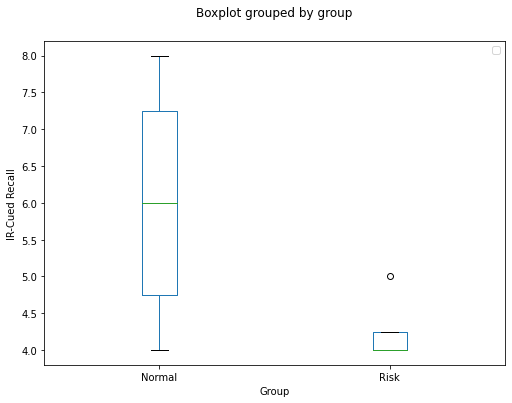

In [0]:
CogMarkers2.boxplot(column = ['IR-CuedR'], by = ['group'], grid = False, figsize = (8,6))
plt.title(None)
plt.xlabel('Group')
plt.ylabel('IR-Cued Recall')
plt.legend()
plt.show()

####**Biomarkers**